In [47]:
from __init__ import PRP; import sys
sys.path.append(PRP)

from scripts.grad_compare import *

from setups.acc.acc_learning import ACCSetup
from tqdm import tqdm
import gc 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
warmup_steps = 1000 
n_iteration = 10 # Number of steps iterations for training
variable_to_perturb = 'temp' # Perturb a variable in the initial state
variable_to_compare = 'temp' # Compare between perturbed and target

Warmup + viz

In [49]:
# Spin-up 
acc = ACCSetup()
acc.setup()

Running model setup


KeyboardInterrupt: 

In [ ]:
def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

In [ ]:
# Spin-up 
acc = ACCSetup()
acc.setup()

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 1000/1000 [00:17<00:00, 57.10it/s]


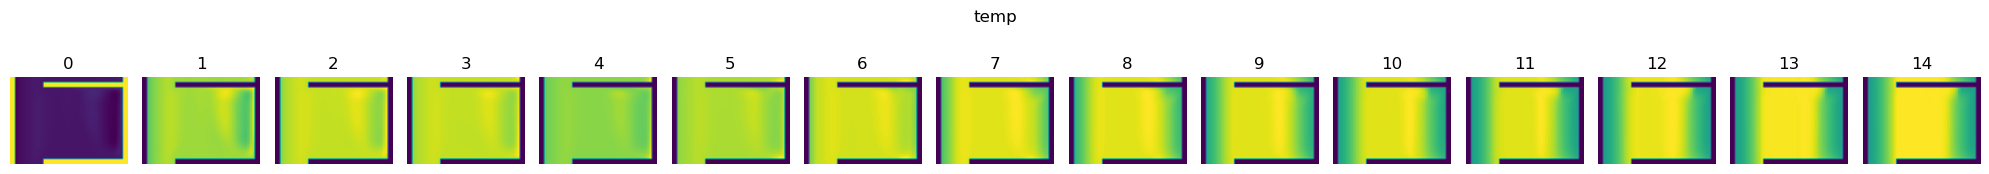

In [ ]:
fig, axs = plt.subplots(1, 15, figsize=(20,2))
    
fig.suptitle(f'{variable_to_compare}')

for i, a in enumerate(axs.ravel()) :
    a.set_title(i)
    a.axis('off')
    a.imshow(getattr(state.variables, variable_to_compare)[..., acc.state.variables.tau][..., i])
fig.tight_layout()

Setup training

In [ ]:
# Build target
state_bf = state.copy()

field_bf = getattr(state_bf.variables, variable_to_perturb).copy()
state_af = state_bf.copy()

for step in tqdm(range(n_iteration)) :
    state_af = step_jit(state_af)

field_af = getattr(state_af.variables, variable_to_compare).copy()

100%|██████████| 10/10 [00:00<00:00, 82.45it/s]


In [ ]:
def gaussian_2d(shape, sigma=5.0):
    """
    Create a normalized 2D Gaussian array centered in the middle of the grid.

    Parameters
    ----------
    shape : tuple of int
        (nx, ny) dimensions of the output array.
    sigma : float or tuple of float, optional
        Standard deviation(s) of the Gaussian. If a single float is given,
        the Gaussian is isotropic; otherwise (sigma_x, sigma_y) are used.

    Returns
    -------
    jnp.ndarray
        Normalized 2D Gaussian of shape (nx, ny).
    """
    nx, ny = shape
    sigma_x, sigma_y = (sigma, sigma) if jnp.ndim(sigma) == 0 else sigma

    x = jnp.arange(nx)
    y = jnp.arange(ny)
    X, Y = jnp.meshgrid(x, y, indexing='ij')

    x0, y0 = (nx - 1) / 2, (ny - 1) / 2

    g = jnp.exp(-(((X - x0)**2) / (2 * sigma_x**2) +
                  ((Y - y0)**2) / (2 * sigma_y**2)))

    return g / jnp.sum(g)

In [ ]:
# Perturb 
state_perturb_bf = state_bf.copy()
state_training_bf = state_bf.copy()


field_perturb_bf = getattr(state_perturb_bf.variables, variable_to_perturb).copy()
#field_perturb_bf += jax.random.normal(jax.random.PRNGKey(0), shape=field_perturb_bf.shape)

# Perturbation 1 : multiply by a scalar
#field_perturb_bf = field_perturb_bf.at[..., state_perturb_bf.variables.tau].multiply(1.3)

# Perturbation 2 : random iid noise 
maskT = state_perturb_bf.variables.maskT
vars = ((1 - state_perturb_bf.variables.zt[None, None, :] / state_perturb_bf.variables.zw[0]))* state_perturb_bf.variables.maskT


#noise = jax.random.normal(jax.random.PRNGKey(0), shape=maskT.shape) * vars 
#field_perturb_bf = field_perturb_bf.at[..., state_perturb_bf.variables.tau].add(noise)

# Perturbation 3 : structured noise
noise =  gaussian_2d(maskT.shape[:-1], sigma=5)[:,:,None] * vars
field_perturb_bf = field_perturb_bf.at[..., state_perturb_bf.variables.tau].add(noise)


# Init noise based on code initialisation for temperature ? 

field_training_bf =  field_perturb_bf.copy() # Save initial perturb field

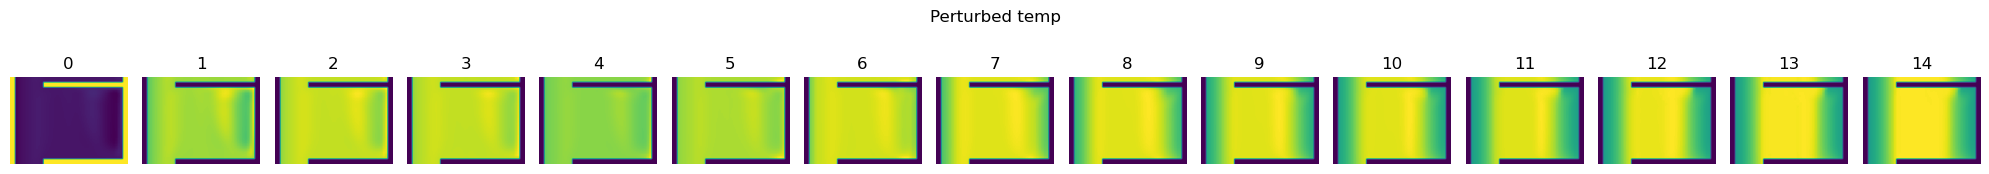

In [ ]:
fig, axs = plt.subplots(1, 15, figsize=(20,2))
    
fig.suptitle(f'Perturbed {variable_to_compare}')

for i, a in enumerate(axs.ravel()) :
    a.set_title(i)
    a.axis('off')
    a.imshow(field_perturb_bf[...,state_perturb_bf.variables.tau][..., i])
fig.tight_layout()

# Gradients 

In [1]:
def agg_sum(state, target_state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    tau_target = getattr(target_state.variables, 'tau')
    return ((getattr(state.variables, key_sum)[...,tau] - getattr(target_state.variables, key_sum)[...,tau_target])**2).mean()

step_function = acc.step
agg_function = lambda state : agg_sum(state, state_af, key_sum=variable_to_compare)

type_grad = 'remat_loop' 

if type_grad == 'compile_loop' :
    vjpm = vjp_grad_new(step_function, agg_function, variable_to_perturb)

    loss_and_grad = lambda s, v: vjpm.g(s, v, iterations=n_iteration)
    loss_and_grad = jax.jit(loss_and_grad)
elif type_grad == 'recursive' : 
    vjpm = vjp_grad(step_function, agg_function, variable_to_perturb)

    vjpm.step_function = jax.jit(vjpm.step_function)
    vjpm.agg_function = jax.jit(vjpm.agg_function)

    loss_and_grad = lambda s, v : vjpm.g(s, v, iterations=n_iteration)
    
elif type_grad == 'remat_loop' : 
    vjpm = vjp_grad_new(acc.step, agg_function, variable_to_perturb)

    vjpm.step_function = jax.jit(vjpm.step_function)
    vjpm.agg_function = jax.jit(vjpm.agg_function)

    vjpm.step_function = jax.checkpoint(vjpm.step_function) # Remat to save memory

    loss_and_grad_nr = lambda s, v, it: vjpm.g(s, v, iterations=n_iteration)

NameError: name 'acc' is not defined

In [ ]:
%%time
output_forward, gradients = loss_and_grad(state_training_bf, field_training_bf)

CPU times: user 1min 20s, sys: 2.89 s, total: 1min 23s
Wall time: 1min 22s


In [ ]:
%%time
output_forward, gradients = loss_and_grad(state_training_bf, field_training_bf)

CPU times: user 3.74 s, sys: 815 ms, total: 4.55 s
Wall time: 4.03 s


In [ ]:
#stats = []
pbar = tqdm(range(1000))
lr = 5.0

#best_output_forward = 10000

for i in pbar:
    output_forward, gradients = loss_and_grad(state_training_bf, field_training_bf)
    
    if jnp.isnan(gradients).sum() > 0 :
        break

    if output_forward < best_output_forward : 
        save_field_training_bf = field_training_bf.copy()
        best_output_forward = output_forward.copy()
        #print(f'Saving field epoch : {i}')
    
    # if output_forward > (prev_output_forward+0.001) : # If loss increase we backup
    #     field_training_bf = prev_training_bf.copy()
    #     lr /= 2
    #     print(f'Decrease learning rate {output_forward}>{prev_output_forward} {lr=}')
    #     continue
    # else :  # If loss decreased we save before update
    #     prev_output_forward = output_forward.copy()
    #     prev_training_bf = field_training_bf.copy()
        
    distance = ((field_training_bf - field_bf) ** 2).mean()
    stats.append({'loss': output_forward, 'distance': distance})
    field_training_bf -= lr * gradients
    pbar.set_postfix(loss=float(output_forward), distance=float(distance))
    if i%100 == 0 : 
        print({'loss': output_forward, 'distance': distance})

  0%|          | 1/1000 [00:04<1:13:39,  4.42s/it, distance=2.67e-7, loss=7.63e-7]

{'loss': Array(7.63364842e-07, dtype=float64), 'distance': Array(2.66627611e-07, dtype=float64)}


 10%|█         | 101/1000 [06:17<52:44,  3.52s/it, distance=2.71e-7, loss=7.06e-7] 

{'loss': Array(7.06259198e-07, dtype=float64), 'distance': Array(2.70587194e-07, dtype=float64)}


 20%|██        | 201/1000 [12:39<46:47,  3.51s/it, distance=2.52e-7, loss=6.52e-7]  

{'loss': Array(6.51932626e-07, dtype=float64), 'distance': Array(2.5158723e-07, dtype=float64)}


 22%|██▏       | 222/1000 [14:03<49:17,  3.80s/it, distance=2.48e-7, loss=6.41e-7]


KeyboardInterrupt: 

# Analyse results

Convergence curve 

Text(0.5, 0.98, 'Learning through 10 iterations with autodiff method : recursive')

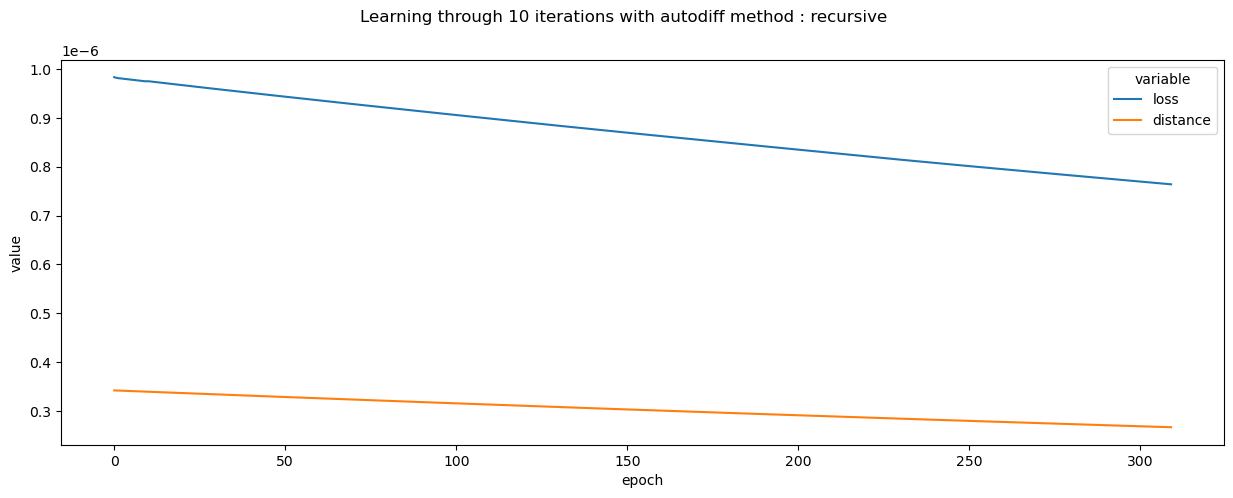

In [ ]:
df = pd.DataFrame(stats).map(lambda x : x.__array__())
df['epoch'] = df.index

fig, axs = plt.subplots(1,1, figsize=(15,5))
sns.lineplot(data=df.melt(id_vars='epoch'), x='epoch', y='value', hue='variable')
fig.suptitle(f'Learning through {n_iteration} iterations with autodiff method : {type_grad}')

Plot results

In [ ]:
# Get prediction (before training)
state_perturb_af = state_perturb_bf.copy()

with state_perturb_af.variables.unlock() :
    setattr(state_perturb_af.variables, variable_to_perturb, field_perturb_bf)

for step in tqdm(range(n_iteration)) :
    acc.step(state_perturb_af)

field_perturb_af = getattr(state_perturb_af.variables, variable_to_perturb).copy()

# Get prediction (after training)
state_training_af = state_training_bf.copy()

with state_training_af.variables.unlock() :
    setattr(state_training_af.variables, variable_to_perturb, field_training_bf)

for step in tqdm(range(n_iteration)) :
    acc.step(state_training_af)

field_training_af = getattr(state_training_af.variables, variable_to_perturb).copy()

100%|██████████| 10/10 [00:00<00:00, 16.55it/s]


In [ ]:
# Recovering initial field 
assert state_bf.variables.tau == state_training_bf.variables.tau, f'Error in the tau of initial state :  {state_bf.variables.tau=} != {state_training_bf.variables.tau=}'
print(f'initial state tau : {state_bf.variables.tau}')

((field_bf - field_training_bf)**2).mean(axis=(0,1,2))

initial state tau : 2


Array([0.00000000e+00, 0.00000000e+00, 7.99882832e-07], dtype=float64)

In [ ]:
# Computing final loss
assert state_af.variables.tau == state_training_af.variables.tau, f'Error in the tau of initial state :  {state_af.variables.tau=} != {state_training_af.variables.tau=}'
print(f'target_state state tau : {state_af.variables.tau}')

((field_af - field_training_af)**2).mean(axis=(0,1,2))

target_state state tau : 0


Array([7.63364878e-07, 7.75625575e-07, 7.70678706e-07], dtype=float64)

In [ ]:
state_training_bf.variables.tau

Array(2, dtype=int32)

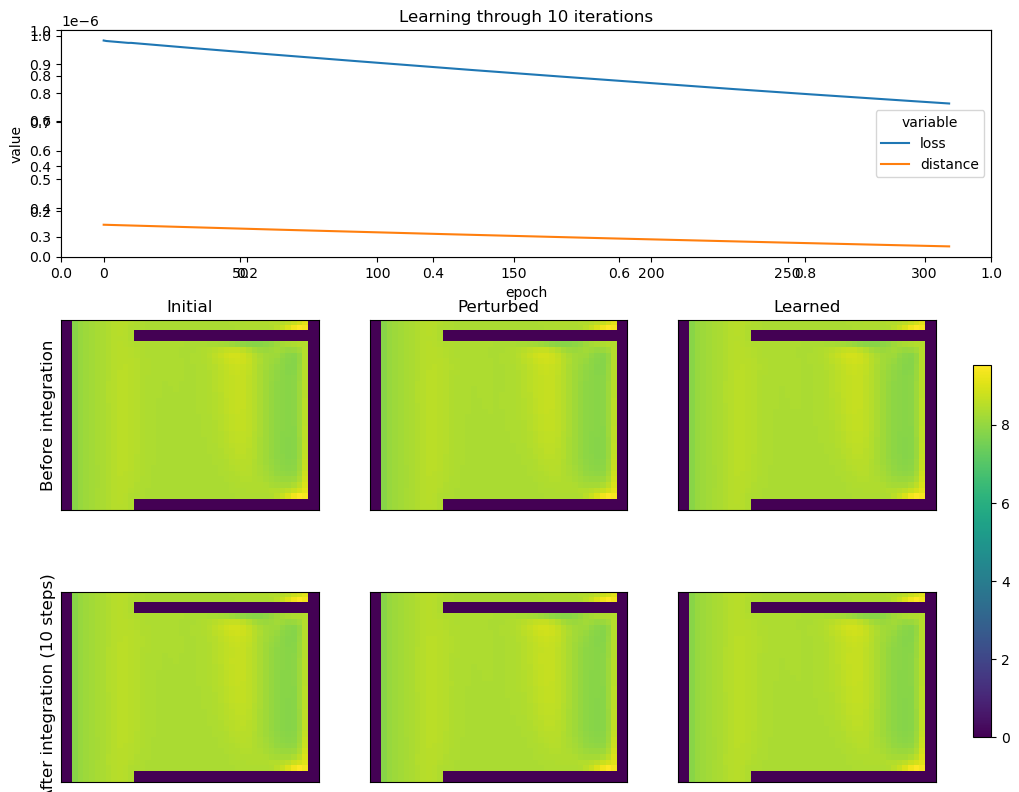

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

vl = 5 # vertical level
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

fig.clear()
gs = GridSpec(3, 3, figure=fig)

# First row: one large axis spanning all columns
ax_top = fig.add_subplot(gs[0, :])

# First row: one large axis spanning all columns
ax_top = fig.add_subplot(gs[0, :])
sns.lineplot(data=df.melt(id_vars='epoch'), x='epoch', y='value', hue='variable', ax=ax_top)
ax_top.set_title(f'Learning through {n_iteration} iterations')


# Shared color scale
vmin, vmax = (
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].min(),
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].max(),
)

# Second and third rows: normal 3×2 grid
ax_imgs = [
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])],
    [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2])]
]

# --- Top image row (before integration) ---
ax_imgs[0][0].imshow(field_bf[ ..., vl, state_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][0].set_title("Initial")

ax_imgs[0][1].imshow(field_perturb_bf[ ..., vl,state_perturb_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][1].set_title("Perturbed")

ax_imgs[0][2].imshow(field_training_bf[ ..., vl, state_training_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][2].set_title("Learned")

# --- Bottom image row (after integration) ---
ax_imgs[1][0].imshow(field_af[ ..., vl,  state_af.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[1][1].imshow(field_perturb_af[ ..., vl,  state_perturb_af.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[1][2].imshow(field_training_af[ ..., vl,  state_training_af.variables.tau], vmin=vmin, vmax=vmax)

# --- Row labels ---
ax_imgs[0][0].set_ylabel("Before integration", fontsize=12)
ax_imgs[1][0].set_ylabel(f"After integration ({n_iteration} steps)", fontsize=12)

# Remove tick labels
for ax_row in ax_imgs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

# Shared colorbar
fig.colorbar(ax_imgs[0][1].images[0], ax=[a for row in ax_imgs for a in row], orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

# Compare State before / after learning

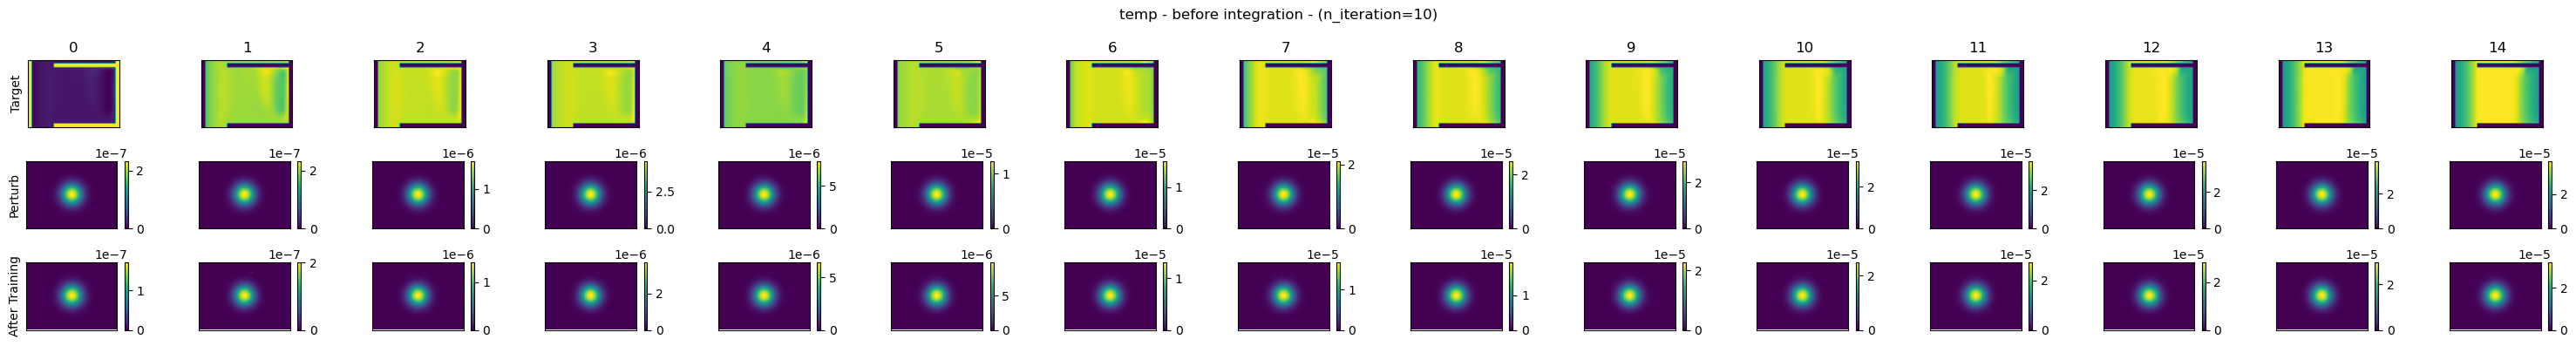

In [ ]:
fig, axs = plt.subplots(3, 15, figsize=(30,4))
[(a.set_yticks([]), a.set_xticks([]))for a in axs.ravel()]
fig.suptitle(f'{variable_to_compare} - before integration - ({n_iteration=})')


for j in range(15) :
    axs[0, j].set_title(f'{j}')
    axs[0, j].imshow(field_bf[...,state_bf.variables.tau][..., j])
    c = axs[1, j].imshow((field_perturb_bf[...,state_perturb_bf.variables.tau][..., j] - field_bf[...,state_bf.variables.tau][..., j])**2)
    fig.colorbar(c, ax=axs[1, j])
    c = axs[2, j].imshow((field_training_bf[...,state_training_bf.variables.tau][..., j] - field_bf[...,state_bf.variables.tau][..., j])**2)
    fig.colorbar(c, ax=axs[2, j])

axs[0, 0].set_ylabel('Target')
axs[1, 0].set_ylabel('Perturb')
axs[2, 0].set_ylabel('After Training')


fig.tight_layout()

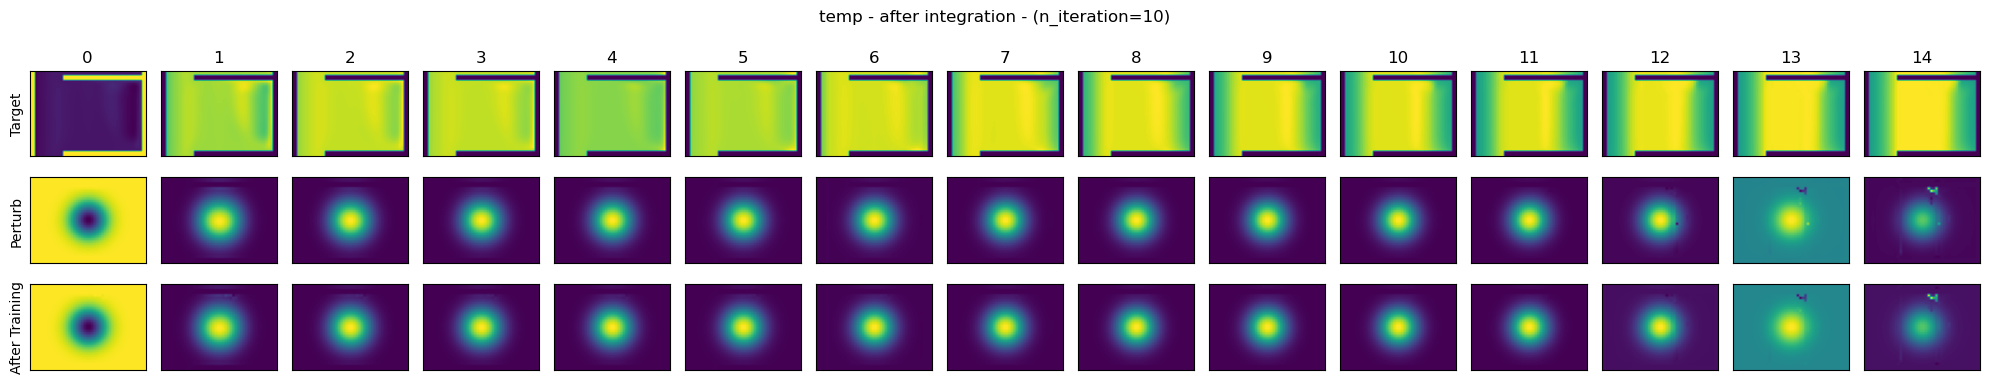

In [ ]:
fig, axs = plt.subplots(3, 15, figsize=(20,4))
[(a.set_yticks([]), a.set_xticks([]))for a in axs.ravel()]
fig.suptitle(f'{variable_to_compare} - after integration - ({n_iteration=})')


for j in range(15) :
    axs[0, j].set_title(f'{j}')
    axs[0, j].imshow(field_af[...,state_af.variables.tau][..., j])
    axs[1, j].imshow(field_perturb_af[...,state_perturb_af.variables.tau][..., j] - field_af[...,state_af.variables.tau][..., j])
    axs[2, j].imshow(field_training_af[...,state_training_af.variables.tau][..., j] - field_af[...,state_af.variables.tau][..., j])
axs[0, 0].set_ylabel('Target')
axs[1, 0].set_ylabel('Perturb')
axs[2, 0].set_ylabel('After Training')



fig.tight_layout()

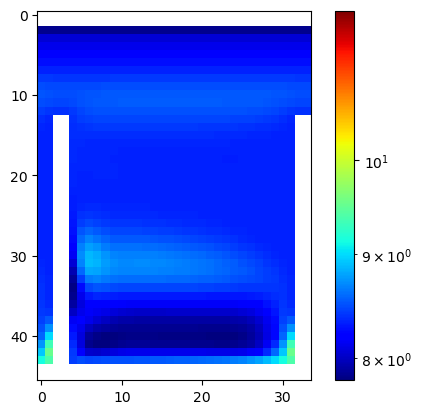

In [ ]:
from matplotlib.colors import LogNorm

plt.imshow(
    field_bf[..., vl, state_bf.variables.tau].T,
    norm=LogNorm(vmin=vmin + 1e-3, vmax=vmax),  # Apply log scaling
    cmap='jet'
)
plt.colorbar()
plt.show()

In [ ]:
import seaborn as sns


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
 (/tmp/ipykernel_82714/2101858023.py:1)


<Axes: ylabel='Density'>

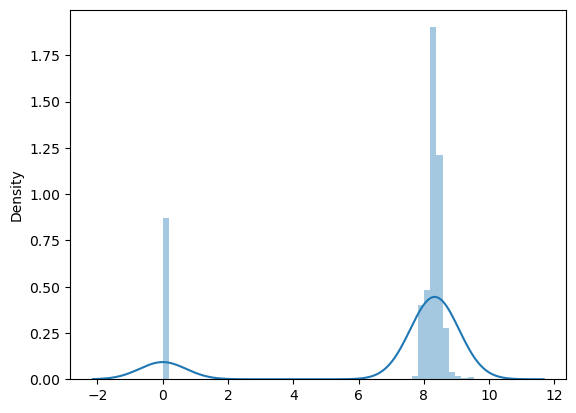

In [ ]:
sns.distplot(field_bf[..., vl, state_bf.variables.tau].flatten())

In [ ]:
# Shared color scale
vmin, vmax = (
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].min(),
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].max(),
)


In [ ]:
vals = field_perturb_bf[..., vl, state_perturb_bf.variables.tau].flatten()

In [ ]:
vmin = vals[vals > 0].min()

In [ ]:
vmax = vals[vals > 0].max()

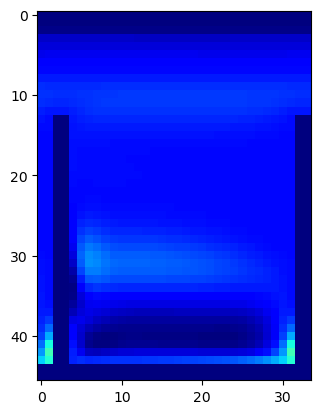

In [ ]:
plt.imshow(
    field_bf[..., vl, state_bf.variables.tau].T,
    vmin=vmin, vmax=vmax,
    cmap='jet'
)

In [ ]:
df

,loss,distance,epoch
0,1.022508,0.342183,0
1,1.021603,0.341892,1
2,1.020687,0.341599,2
3,1.019771,0.341307,3
4,1.018874,0.341019,4
...,...,...,...
9995,0.000581,0.030570,9995
9996,0.000581,0.030570,9996
9997,0.000580,0.030570,9997
9998,0.000580,0.030569,9998


In [ ]:
df.to_csv('learning_perturb.csv')

In [ ]:
np.save(f'field_bf_tau={state_bf.variables.tau.item()}.npy', field_bf)
np.save(f'field_af_tau={state_af.variables.tau.item()}.npy', field_af)

np.save(f'field_perturb_bf_tau={state_perturb_bf.variables.tau.item()}.npy', field_perturb_bf)
np.save(f'field_perturb_af_tau={state_perturb_af.variables.tau.item()}.npy', field_perturb_af)

np.save(f'field_training_bf_tau={state_training_bf.variables.tau.item()}.npy', field_training_bf)
np.save(f'field_training_af_tau={state_training_af.variables.tau.item()}.npy', field_training_af)

In [ ]:



# Shared color scale
vmin, vmax = (
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].min(),
    field_perturb_bf[..., vl, state_perturb_bf.variables.tau].max(),
)

# Second and third rows: normal 3×2 grid
ax_imgs = [
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])],
    [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2])]
]

# --- Top image row (before integration) ---
ax_imgs[0][0].imshow(field_bf[ ..., vl, state_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][0].set_title("Initial")

ax_imgs[0][1].imshow(field_perturb_bf[ ..., vl,state_perturb_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][1].set_title("Perturbed")

ax_imgs[0][2].imshow(field_training_bf[ ..., vl, state_training_bf.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[0][2].set_title("Learned")

# --- Bottom image row (after integration) ---
ax_imgs[1][0].imshow(field_af[ ..., vl,  state_af.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[1][1].imshow(field_perturb_af[ ..., vl,  state_perturb_af.variables.tau], vmin=vmin, vmax=vmax)
ax_imgs[1][2].imshow(field_training_af[ ..., vl,  state_training_af.variables.tau], vmin=vmin, vmax=vmax)

# --- Row labels ---
ax_imgs[0][0].set_ylabel("Before integration", fontsize=12)
ax_imgs[1][0].set_ylabel(f"After integration ({n_iteration} steps)", fontsize=12)

# Remove tick labels
for ax_row in ax_imgs:
    for ax in ax_row:
        ax.set_xticks([])
        ax.set_yticks([])

# Shared colorbar
fig.colorbar(ax_imgs[0][1].images[0], ax=[a for row in ax_imgs for a in row], orientation='vertical', fraction=0.02, pad=0.04)

plt.show()